# 🔬 Predicting Diabetes & Diabetic Eye Risk (PIMA Extended + Retina)

Ce notebook présente une étude complète sur la prédiction du **diabète** à partir
d’un jeu de données tabulaire enrichi (extension du dataset PIMA + variables
cliniques modernes).

Objectifs :

- Explorer rapidement le dataset (variables, distribution de la cible).
- Construire plusieurs modèles de classification :
  - Régression logistique (baseline linéaire)
  - Random Forest (modèle non linéaire)
  - HistGradientBoosting (gradient boosting moderne)
- Comparer leurs performances (Accuracy, Recall, F1, ROC AUC).
- Préparer un **pipeline sklearn “production ready”** exporté en `.joblib`
  pour être utilisé par une API FastAPI et un frontend React.


## 🧭 Plan du notebook

1. Imports et chargement des données  
2. Aperçu des variables et de la cible  
3. Prétraitement des données (nettoyage & features)  
4. Préparation des données pour les modèles tabulaires  
5. Modèle 1 – Régression logistique (baseline)  
6. Modèle 2 – Random Forest  
7. Modèle 3 – HistGradientBoosting  
8. Comparaison globale des modèles  
9. Visualisations exploratoires (Age, Glycémie, corrélations…)  
10. Pipeline Random Forest “production” + export `.joblib`  
11. Conclusion & lien avec l’API FastAPI


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Affichage plus joli
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")

# 🔹 Chemin vers le dataset
DATA_PATH = Path("../data/diabetes.csv")  # adapter si nécessaire

# 🔹 Chargement
data = pd.read_csv(DATA_PATH, sep=";")

print("✅ Dataset chargé avec succès")
print("Shape :", data.shape)

# Aperçu rapide
data.head()


✅ Dataset chargé avec succès
Shape : (50000, 19)


,gender,Age,Pregnancies,Glucose,blood_glucose_level,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,hypertension,heart_disease,smoking_history,HbA1c_level,Outcome,left_image_path,right_image_path,left_DR_stage,right_DR_stage
0,Female,39,4,146,146.0,84,40,133,34.4,0.265,0,0,never,8.2,1,data\diabetic_retinopathy\train\535682537302.jpg,data\diabetic_retinopathy\train\870f433e8f37.jpg,0.0,0.0
1,Female,36,12,93,93.0,64,47,111,38.6,0.184,0,0,former,6.6,0,NaN,NaN,NaN,NaN
2,Female,57,7,119,119.0,66,0,0,35.9,0.537,0,0,never,6.0,0,NaN,NaN,NaN,NaN
3,Male,25,0,100,100.0,74,52,0,25.4,0.354,0,0,No Info,3.5,0,NaN,NaN,NaN,NaN
4,Male,26,0,122,122.0,70,0,8,33.8,0.202,0,0,never,8.8,1,data\diabetic_retinopathy\train\454a944eb557.jpg,data\diabetic_retinopathy\train\b1c6f0997e27.jpg,0.0,0.0


## 1. Aperçu des variables et vérification de la cible

Dans cette section, on :

- liste les colonnes disponibles,
- vérifie les types de variables,
- regarde la distribution de la variable cible `Outcome`
  (0 = non diabétique, 1 = diabétique),
- vérifie s’il y a un **déséquilibre de classes**.


Liste des colonnes :
['gender', 'Age', 'Pregnancies', 'Glucose', 'blood_glucose_level', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'Outcome', 'left_image_path', 'right_image_path', 'left_DR_stage', 'right_DR_stage']

Types de données :
gender                       object
Age                           int64
Pregnancies                   int64
Glucose                       int64
blood_glucose_level         float64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
hypertension                  int64
heart_disease                 int64
smoking_history              object
HbA1c_level                 float64
Outcome                       int64
left_image_path              object
right_image_path             object
left_DR_stage               float64
right_DR_sta

,Age,Pregnancies,Glucose,blood_glucose_level,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,hypertension,heart_disease,HbA1c_level,Outcome,left_DR_stage,right_DR_stage
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,24961.000000,24961.000000
mean,34.313600,4.157980,124.363980,124.363980,68.533320,20.570660,86.897960,32.248536,0.473170,0.104780,0.028780,6.158802,0.499220,1.072753,1.072753
std,11.956141,3.576042,35.339481,35.339481,20.846013,16.136274,119.067448,7.552847,0.343792,0.306273,0.167189,1.272169,0.500004,1.243378,1.243378
min,21.000000,0.000000,44.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.088000,0.000000,0.000000,3.500000,0.000000,0.000000,0.000000
25%,24.000000,1.000000,101.000000,101.000000,62.000000,0.000000,0.000000,27.600000,0.236000,0.000000,0.000000,5.700000,0.000000,0.000000,0.000000
50%,31.000000,3.000000,121.000000,121.000000,72.000000,23.000000,30.000000,32.500000,0.360000,0.000000,0.000000,6.100000,0.000000,0.000000,0.000000
75%,42.000000,7.000000,149.000000,149.000000,80.000000,33.000000,144.000000,36.700000,0.622000,0.000000,0.000000,6.600000,1.000000,2.000000,2.000000
max,68.000000,13.000000,197.000000,197.000000,108.000000,54.000000,545.000000,52.900000,1.781000,1.000000,1.000000,9.000000,1.000000,4.000000,4.000000



Répartition de la cible Outcome :
Outcome
0    25039
1    24961
Name: count, dtype: int64

Proportions :
Outcome
0    0.50078
1    0.49922
Name: count, dtype: float64


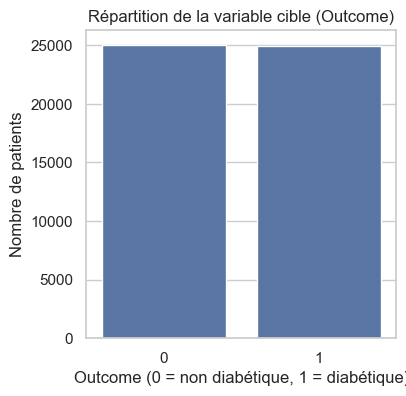

In [2]:
print("Liste des colonnes :")
print(list(data.columns))

print("\nTypes de données :")
print(data.dtypes)

print("\nRésumé statistique des variables numériques :")
display(data.describe())

# Distribution de la cible
counts = data["Outcome"].value_counts().sort_index()
proportions = counts / counts.sum()

print("\nRépartition de la cible Outcome :")
print(counts)
print("\nProportions :")
print(proportions)

plt.figure(figsize=(4, 4))
sns.countplot(data=data, x="Outcome")
plt.title("Répartition de la variable cible (Outcome)")
plt.xlabel("Outcome (0 = non diabétique, 1 = diabétique)")
plt.ylabel("Nombre de patients")
plt.show()


## 3. Répartition du diabète dans le dataset

Nous examinons ici combien de patient·es sont :

- **non diabétiques** (`Outcome = 0`)
- **diabétiques** (`Outcome = 1`)

et les pourcentages associés.

Cette information est importante pour :

- comprendre l'équilibre des classes,
- choisir les bonnes métriques d'évaluation (accuracy, F1, AUC, etc.),
- décider éventuellement d'utiliser un rééchantillonnage (SMOTE, class_weight, etc.).


In [4]:
counts = data["Outcome"].value_counts().sort_index()
percentages = (counts / len(data) * 100).round(2)

summary = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
summary.index = ["Non diabétique (0)", "Diabétique (1)"]

print("Répartition des classes :")
summary


Répartition des classes :


,count,percentage
Non diabétique (0),25039,50.08
Diabétique (1),24961,49.92


## 4. Prétraitement des données pour le Modèle 1 (tabulaire)

Pour le premier modèle, nous voulons prédire `Outcome` à partir **des variables
cliniques uniquement**.

Les colonnes liées aux images de rétine seront utilisées plus tard dans un modèle
de vision (YOLO / CNN) et ne doivent pas intervenir ici.

### Étapes de nettoyage :

1. **Supprimer les colonnes non utilisées pour le Modèle 1 :**
   - `left_image_path`, `right_image_path`, `left_DR_stage`, `right_DR_stage`
   - `blood_glucose_level` (dupliqué de `Glucose`)

2. **Convertir la glycémie et clarifier l’unité :**
   - la colonne `Glucose` est exprimée en mg/dL (format classique du dataset Pima),
   - nous la convertissons en g/L en divisant par 100,
   - puis nous la renommons en `Glycemia_gL` pour rendre l’unité explicite.

3. **Traiter les valeurs 0 comme manquantes** pour certaines mesures
   (une glycémie ou une pression artérielle égale à 0 n’est pas réaliste) :
   - `Glycemia_gL`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`

4. **Imputer les valeurs manquantes** par la médiane de chaque colonne concernée.

Le DataFrame nettoyé sera stocké dans la variable `data_clean` et servira de base
pour l'entraînement du modèle tabulaire.


In [5]:
## 4. Prétraitement des données pour le Modèle 1

# 1) Colonnes à exclure du Modèle 1
retina_cols = ["left_image_path", "right_image_path", "left_DR_stage", "right_DR_stage"]
duplicate_cols = ["blood_glucose_level"]  # info déjà contenue dans Glucose

cols_to_drop = retina_cols + duplicate_cols

data_clean = data.drop(columns=cols_to_drop).copy()

print("Colonnes après suppression des colonnes inutiles :")
print(list(data_clean.columns))

# 2) Conversion de la glycémie : mg/dL -> g/L et renommage
#    (1 g/L = 100 mg/dL, donc on divise par 100)
data_clean["Glucose"] = data_clean["Glucose"] / 100.0
data_clean.rename(columns={"Glucose": "Glycemia_gL"}, inplace=True)

print("\nColonne de glycémie renommée et convertie :")
print(data_clean[["Glycemia_gL"]].head())

# 3) Colonnes où 0 = valeur manquante (non réaliste)
cols_with_zero_as_missing = ["Glycemia_gL", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Remplacer les 0 par NaN
data_clean[cols_with_zero_as_missing] = (
    data_clean[cols_with_zero_as_missing].replace(0, np.nan)
)

print("\nNombre de valeurs manquantes après remplacement des zéros :")
print(data_clean[cols_with_zero_as_missing].isna().sum())

# 4) Imputation : remplacer les NaN par la médiane de chaque colonne
for col in cols_with_zero_as_missing:
    median_value = data_clean[col].median()
    data_clean[col].fillna(median_value, inplace=True)

print("\nValeurs manquantes après imputation (devrait être 0 partout) :")
print(data_clean.isna().sum())


Colonnes après suppression des colonnes inutiles :
['gender', 'Age', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'Outcome']

Colonne de glycémie renommée et convertie :
   Glycemia_gL
0         1.46
1         0.93
2         1.19
3         1.00
4         1.22

Nombre de valeurs manquantes après remplacement des zéros :
Glycemia_gL          0
BloodPressure     1878
SkinThickness    15349
Insulin          23567
BMI                 29
dtype: int64

Valeurs manquantes après imputation (devrait être 0 partout) :
gender                      0
Age                         0
Pregnancies                 0
Glycemia_gL                 0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
hypertension                0
heart_disease               0
smoking_history             0

C:\Users\klever\AppData\Local\Temp\ipykernel_6256\3178705096.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean[col].fillna(median_value, inplace=True)
C:\Users\klever\AppData\Local\Temp\ipykernel_6256\3178705096.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

## 4.2. Amélioration de la variable `smoking_history`

La variable `smoking_history` contient plusieurs modalités qui se recoupent :

- `never`
- `former`
- `current`
- `ever`
- `not current`
- `No Info`

Pour le modèle, ce niveau de détail n'apporte pas forcément plus
d'information et complique l'interprétation. De plus, la modalité
`No Info` représente en réalité une **donnée manquante**.

Nous regroupons donc ces catégories en trois états plus simples :

- **`never`** : n'a jamais fumé  
- **`smoker`** : a fumé dans sa vie (ancien fumeur ou fumeur actuel)  
  (`current`, `former`, `ever`, `not current`)
- **`unknown`** : information manquante (`No Info`)

Nous créons une nouvelle colonne `smoking_status` avec ces 3 valeurs,
puis nous supprimons l'ancienne colonne `smoking_history`.


In [6]:
## 10. Nettoyage de la variable smoking_history

print("Modalités initiales de smoking_history :")
print(data_clean["smoking_history"].value_counts())

def map_smoking_status(x: str) -> str:
    if x == "never":
        return "never"
    elif x in ["current", "former", "ever", "not current"]:
        return "smoker"
    else:
        # No Info ou toute autre valeur inattendue
        return "unknown"

data_clean["smoking_status"] = data_clean["smoking_history"].apply(map_smoking_status)

print("\nNouvelle répartition de smoking_status :")
print(data_clean["smoking_status"].value_counts())

# On peut maintenant supprimer l'ancienne colonne
data_clean = data_clean.drop(columns=["smoking_history"])


Modalités initiales de smoking_history :
smoking_history
never          20291
No Info        11255
current         7471
former          4362
not current     3905
ever            2716
Name: count, dtype: int64

Nouvelle répartition de smoking_status :
smoking_status
never      20291
smoker     18454
unknown    11255
Name: count, dtype: int64


## 5. Encodage des variables catégorielles et séparation Train / Test

Nous disposons maintenant d'un jeu de données nettoyé dans `data_clean`.

Prochaine étape :

1. **Encoder les variables catégorielles** :
   - `gender`
   - `smoking_history`
   
   Nous utilisons un encodage *one-hot* (via `pd.get_dummies`) avec `drop_first=True`
   pour éviter la multicolinéarité.

2. **Séparer les features et la cible** :
   - `X` : toutes les colonnes explicatives,
   - `y` : la variable cible `Outcome`.

3. **Diviser les données en ensemble d'entraînement et de test** :
   - 80 % pour l'entraînement,
   - 20 % pour le test,
   - en **stratifiant** sur `Outcome` pour conserver la même proportion de
     diabétiques / non diabétiques dans les deux ensembles.

Ces ensembles (`X_train`, `X_test`, `y_train`, `y_test`) seront utilisés pour
entraîner et évaluer nos modèles tabulaires (régression logistique, Random Forest, etc.).


In [7]:
from sklearn.model_selection import train_test_split

## 5. Encodage et split

target_column = "Outcome"

# Colonnes catégorielles à encoder
categorical_cols = ["gender", "smoking_status"]

# Encodage one-hot
data_model = pd.get_dummies(
    data_clean,
    columns=categorical_cols,
    drop_first=True  # évite les variables parfaitement colinéaires
)

print("Colonnes finales après encodage :")
print(list(data_model.columns))

# Séparation X / y
X = data_model.drop(columns=[target_column])
y = data_model[target_column]

# Split train / test (80 / 20) avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nShapes des ensembles :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)


Colonnes finales après encodage :
['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level', 'Outcome', 'gender_Male', 'gender_Other', 'smoking_status_smoker', 'smoking_status_unknown']

Shapes des ensembles :
X_train : (40000, 15)
X_test  : (10000, 15)
y_train : (40000,)
y_test  : (10000,)


## 6. Modèle de base : Régression Logistique

Pour commencer, nous entraînons un **modèle linéaire simple** :  
la **Régression Logistique**.

Objectifs de cette étape :

- obtenir un **premier baseline** de performance,
- vérifier que le pipeline de préparation des données fonctionne bien,
- disposer d’un point de comparaison pour des modèles plus complexes
  (par exemple Random Forest, XGBoost, etc.).

### Choix techniques

- Nous utilisons un `Pipeline` scikit-learn :
  - `StandardScaler` : standardisation des features (moyenne 0, écart-type 1),  
    recommandé pour les modèles linéaires.
  - `LogisticRegression` : modèle linéaire binaire avec pénalisation L2.

- Nous évaluons le modèle sur le jeu de test avec :
  - Accuracy (taux de bonnes prédictions),
  - Precision, Recall, F1-score,
  - Matrice de confusion,
  - AUC ROC (capacité à séparer les classes).


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

## 6. Modèle de base : Régression Logistique

# Pipeline : standardisation + régression logistique
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

# Entraînement
log_reg_pipeline.fit(X_train, y_train)

# Prédictions
y_pred = log_reg_pipeline.predict(X_test)
y_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Métriques
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("✅ Résultats - Régression Logistique (baseline)")
print(f"Accuracy :  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall :   {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC :  {auc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))


✅ Résultats - Régression Logistique (baseline)
Accuracy :  0.8302
Precision: 0.8349
Recall :   0.8225
F1-score : 0.8287
ROC AUC :  0.9192

Classification report :
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5008
           1       0.83      0.82      0.83      4992

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



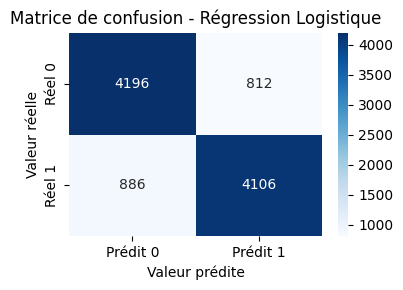

In [9]:
## Matrice de confusion

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"])
plt.title("Matrice de confusion - Régression Logistique")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.tight_layout()
plt.show()


## 7. Modèle non linéaire : Random Forest

Après la régression logistique (modèle linéaire), nous testons un modèle plus
flexible : la **Random Forest**.

### Pourquoi une Random Forest ?

- C'est un ensemble d'arbres de décision entraînés sur des sous-échantillons
  des données.
- Elle capture naturellement des **relations non linéaires** et des
  **interactions** entre variables.
- Elle gère bien les features de types variés et est assez robuste au bruit.

### Objectifs :

- Comparer ses performances à la régression logistique (baseline).
- Observer si le modèle gagne en Recall / F1-score.
- Extraire l'**importance des variables** pour voir quels facteurs contribuent
  le plus à la prédiction du diabète.

Nous utilisons ici une Random Forest avec des hyperparamètres simples
(`n_estimators=300`, `random_state=42`), et nous évaluons les mêmes métriques
qu'auparavant : Accuracy, Precision, Recall, F1, AUC ROC.


### 7.1. Simplification de la variable `gender`

L'encodage one-hot a créé deux colonnes pour le genre :

- `gender_Male`
- `gender_Other` (catégorie très rare et sans importance pour le modèle)

Pour simplifier l'interprétation, nous décidons de :

- **conserver uniquement** la variable binaire `gender_Male`,
- **supprimer `gender_Other`**, ce qui revient à regrouper les rares valeurs
  "Other" avec la catégorie de référence (ici, principalement "Female").

Nous recréons ensuite `X`, `y`, et la séparation train/test avec ce schéma simplifié.


In [10]:
## 7.1. Simplification du genre : suppression de gender_Other

data_model_simple = data_model.copy()

if "gender_Other" in data_model_simple.columns:
    data_model_simple = data_model_simple.drop(columns=["gender_Other"])
    print("Colonne 'gender_Other' supprimée.")
else:
    print("Colonne 'gender_Other' absente (déjà supprimée).")

print("\nNouvelles colonnes :")
print(list(data_model_simple.columns))

# Recréer X, y et le split train/test avec ce schéma simplifié
X = data_model_simple.drop(columns=[target_column])
y = data_model_simple[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nShapes des ensembles (après simplification du genre) :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)


Colonne 'gender_Other' supprimée.

Nouvelles colonnes :
['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level', 'Outcome', 'gender_Male', 'smoking_status_smoker', 'smoking_status_unknown']

Shapes des ensembles (après simplification du genre) :
X_train : (40000, 14)
X_test  : (10000, 14)
y_train : (40000,)
y_test  : (10000,)


In [11]:
from sklearn.ensemble import RandomForestClassifier

## 7. Modèle Random Forest

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Métriques
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("✅ Résultats - Random Forest")
print(f"Accuracy :  {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall :   {rec_rf:.4f}")
print(f"F1-score : {f1_rf:.4f}")
print(f"ROC AUC :  {auc_rf:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred_rf))


✅ Résultats - Random Forest
Accuracy :  0.8607
Precision: 0.8567
Recall :   0.8658
F1-score : 0.8612
ROC AUC :  0.9452

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5008
           1       0.86      0.87      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



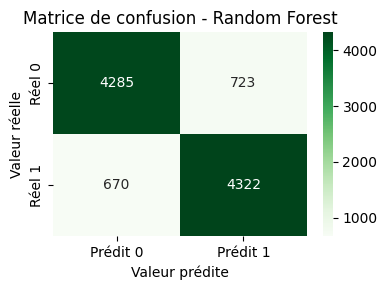

In [12]:
## Matrice de confusion - Random Forest

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"])
plt.title("Matrice de confusion - Random Forest")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.tight_layout()
plt.show()


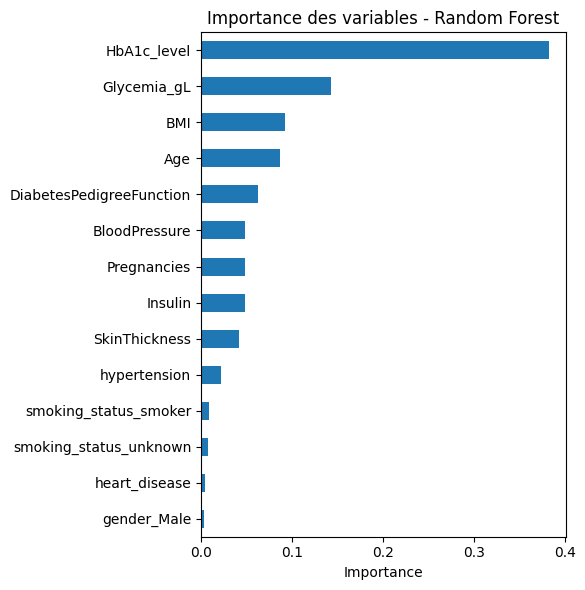

In [13]:
## Importance des variables

importances = rf_clf.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(6, 6))
feat_imp.plot(kind="barh")
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 8. Comparaison des modèles tabulaires

Nous avons entraîné deux modèles différents sur les mêmes données :

1. **Régression Logistique**  
   - Modèle linéaire (baseline)
   - Rapide, facilement interprétable

2. **Random Forest**  
   - Modèle d'ensemble non linéaire
   - Capable de capturer des interactions complexes entre variables

Dans cette section, nous comparons leurs performances sur le jeu de test :

- Accuracy
- Precision
- Recall
- F1-score
- AUC ROC

Puis nous traçons les **courbes ROC** des deux modèles sur le même graphique
pour visualiser leur capacité à séparer diabétiques et non-diabétiques.


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

## 8.1. (Re)entraînement rapide des deux modèles sur le X_train / y_train ACTUELS

# Logistic Regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])
log_reg_pipeline.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

## 8.2. Prédictions et métriques

# Logistic Regression
y_pred_log = log_reg_pipeline.predict(X_test)
y_proba_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_proba_log)

# Random Forest
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

## 8.3. Tableau comparatif

results = pd.DataFrame({
    "Modèle": ["Régression Logistique", "Random Forest"],
    "Accuracy": [acc_log, acc_rf],
    "Precision": [prec_log, prec_rf],
    "Recall": [rec_log, rec_rf],
    "F1-score": [f1_log, f1_rf],
    "ROC AUC": [auc_log, auc_rf]
}).set_index("Modèle")

results.round(4)


,Accuracy,Precision,Recall,F1-score,ROC AUC
Modèle,,,,,
Régression Logistique,0.8302,0.8349,0.8225,0.8287,0.9192
Random Forest,0.8607,0.8567,0.8658,0.8612,0.9452


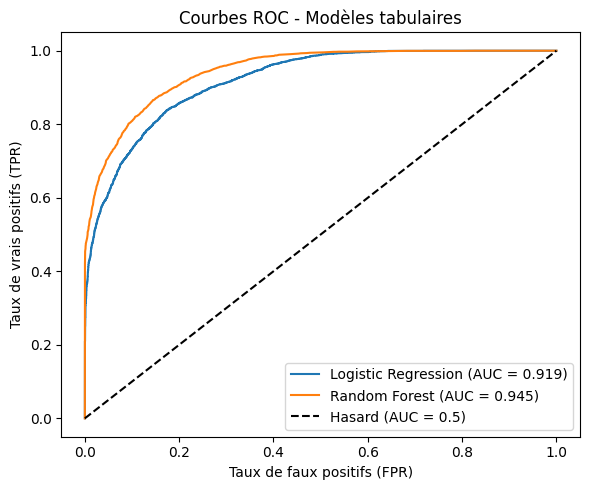

In [15]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Hasard (AUC = 0.5)")

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC - Modèles tabulaires")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## 9. Interprétation des résultats des modèles tabulaires

### 9.1. Bilan des performances

Nous avons comparé deux modèles supervisés entraînés sur les mêmes données
(tabulaire uniquement, sans les images de rétine) :

| Modèle                  | Accuracy | Precision | Recall | F1-score | ROC AUC |
|-------------------------|----------|-----------|--------|----------|---------|
| Régression Logistique   | ~0.83    | ~0.84     | ~0.82  | ~0.83    | ~0.92   |
| Random Forest           | ~0.86    | ~0.86     | ~0.86  | ~0.86    | ~0.95   |

Principales observations :

- La **Random Forest** surpasse la **régression logistique** sur toutes les
  métriques (accuracy, precision, recall, F1 et AUC ROC).
- Les deux modèles ont des performances équilibrées sur les classes
  0 (non diabétique) et 1 (diabétique), ce qui est cohérent avec la
  répartition quasi 50/50 du jeu de données.
- Les courbes ROC montrent que les deux modèles séparent bien les classes
  (AUC > 0.9), mais la Random Forest offre une marge de sécurité supplémentaire.

En pratique, nous retiendrons donc **la Random Forest comme meilleur modèle
tabulaire (Modèle 1)** pour la prédiction du diabète à partir des variables
cliniques.

### 9.2. Variables les plus importantes

L'analyse de l'importance des features de la Random Forest montre que les
facteurs suivants contribuent le plus à la prédiction :

1. **HbA1c_level**  
2. **Glycemia_gL** (taux de glycémie en g/L)  
3. **BMI** (indice de masse corporelle)  
4. **Age**  
5. **DiabetesPedigreeFunction**  

Ce résultat est cohérent d’un point de vue médical :

- l’**HbA1c** et la **glycémie** sont directement liées au contrôle du sucre,
- le **BMI** et l’**âge** sont des facteurs de risque bien connus,
- l’historique familial (DiabetesPedigreeFunction) joue aussi un rôle.

Les autres variables (pression artérielle, insulin, antécédents, tabagisme,
etc.) ont une importance plus faible mais contribuent à affiner la décision.

### 9.3. Transition vers le Modèle 2 (images de rétine)

Pour l’instant, nous avons utilisé uniquement les **données cliniques**.
Les colonnes liées aux images (`left_image_path`, `right_image_path`,
`left_DR_stage`, `right_DR_stage`) ont volontairement été exclues.

Dans la suite du projet, nous exploiterons ces informations pour construire
un **Modèle 2** basé sur la vision par ordinateur (par exemple YOLO / CNN),
capable de détecter les signes de rétinopathie diabétique à partir des
rétinographies.

L’objectif final sera de **combiner les deux sources d’information** :

- Modèle 1 : risque de diabète à partir des données cliniques,
- Modèle 2 : risque de complication oculaire (rétinopathie) à partir des images.


## 10. Visualisations exploratoires

### 10.1. Distribution de l'âge selon le statut diabétique

Ce graphique montre la distribution des âges pour les patient·es :

- non diabétiques (`Outcome = 0`)
- diabétiques (`Outcome = 1`)

Il permet de voir si le diabète est plus fréquent à partir d'un certain âge.


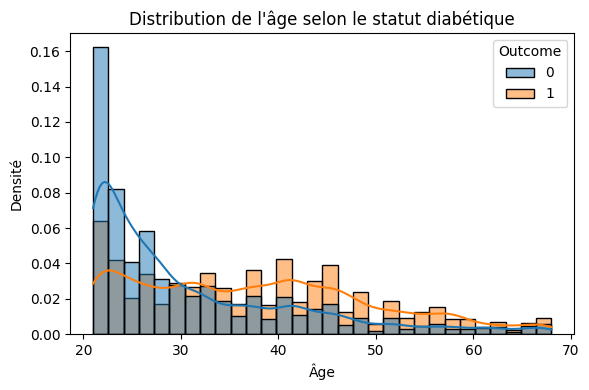

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(
    data=data_clean,
    x="Age",
    hue="Outcome",
    bins=30,
    stat="density",
    common_norm=False,
    kde=True
)
plt.title("Distribution de l'âge selon le statut diabétique")
plt.xlabel("Âge")
plt.ylabel("Densité")
plt.tight_layout()
plt.show()


### 11.2. Variables cliniques clés vs diabète

Nous comparons ici la distribution de :

- `Glycemia_gL` (glycémie)
- `HbA1c_level`
- `BMI`

en fonction du statut diabétique (`Outcome`).

Les boxplots permettent de visualiser les différences de médiane et de
dispersion entre les patient·es diabétiques et non diabétiques.


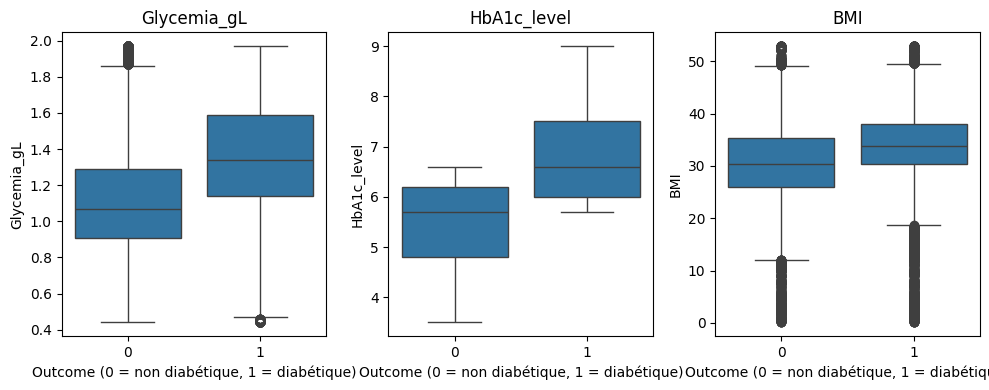

In [17]:
vars_to_plot = ["Glycemia_gL", "HbA1c_level", "BMI"]

plt.figure(figsize=(10, 4))
for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=data_clean, x="Outcome", y=col)
    plt.xlabel("Outcome (0 = non diabétique, 1 = diabétique)")
    plt.title(col)

plt.tight_layout()
plt.show()


### 11.3. Corrélation entre les variables numériques

Ce heatmap montre les corrélations linéaires entre les principales
variables numériques (âge, glycémie, HbA1c, BMI, etc.).

Il aide à repérer :

- des redondances éventuelles,
- des liens forts avec la cible `Outcome`.


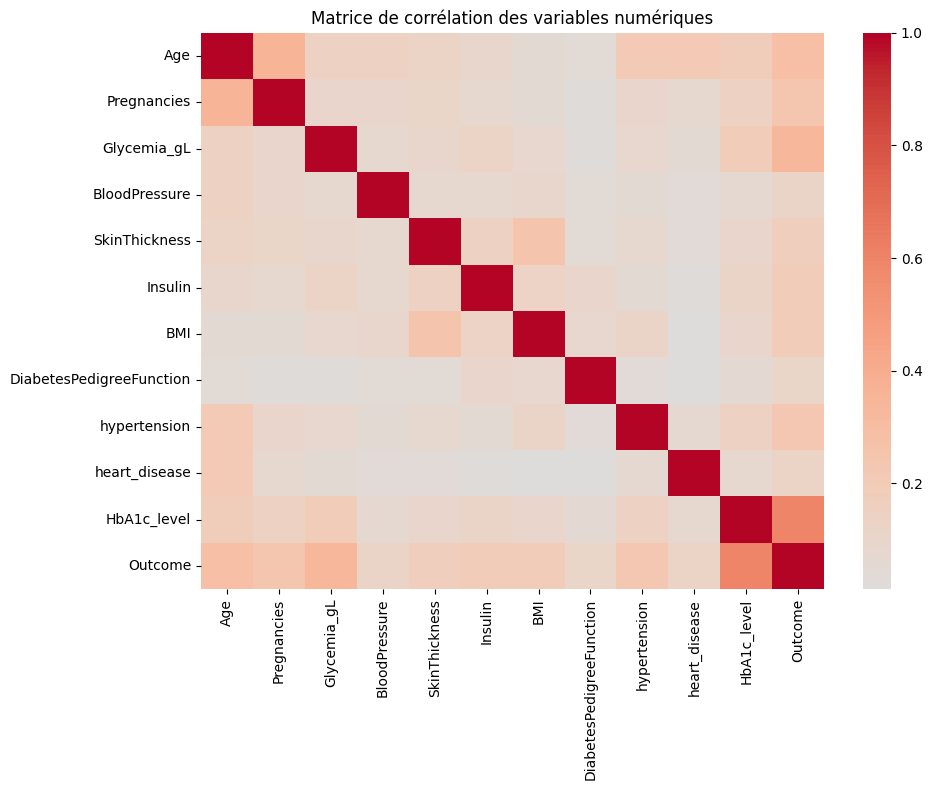

In [18]:
numeric_cols = data_clean.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(10, 8))
corr = data_clean[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()


### 11.4. Prévalence du diabète selon le tabagisme et l'hypertension

Nous observons ici la proportion de patient·es diabétiques selon :

- le statut de tabagisme (`smoking_status`)  
- la présence d'hypertension (`hypertension`)

Ces graphiques permettent d'illustrer l'impact de certains facteurs de
risque sur la probabilité d'être diabétique.


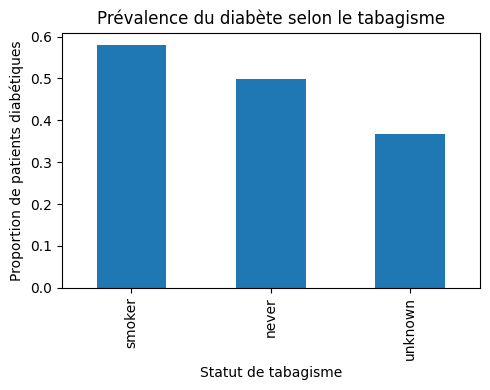

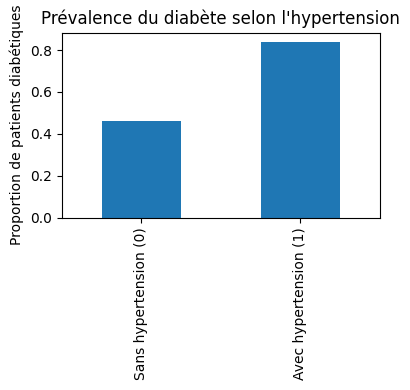

In [19]:
# 11.4.1. Diabète selon statut de tabagisme
smoke_grp = (
    data_clean
    .groupby("smoking_status")["Outcome"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(5, 4))
smoke_grp.plot(kind="bar")
plt.ylabel("Proportion de patients diabétiques")
plt.xlabel("Statut de tabagisme")
plt.title("Prévalence du diabète selon le tabagisme")
plt.tight_layout()
plt.show()

# 11.4.2. Diabète selon hypertension
ht_grp = (
    data_clean
    .groupby("hypertension")["Outcome"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(4, 4))
ht_grp.index = ["Sans hypertension (0)", "Avec hypertension (1)"]
ht_grp.plot(kind="bar")
plt.ylabel("Proportion de patients diabétiques")
plt.title("Prévalence du diabète selon l'hypertension")
plt.tight_layout()
plt.show()


## 12. Modèle 3 : Gradient Boosting (HistGradientBoostingClassifier)

Pour compléter la comparaison, nous ajoutons un troisième modèle :

- **HistGradientBoostingClassifier** (scikit-learn)  
  → une implémentation moderne du **gradient boosting** basée sur des
  histogrammes (performances proches de XGBoost / LightGBM).

Caractéristiques :

- Modèle d'ensemble d'arbres, comme la Random Forest, mais
  - construit les arbres **de manière séquentielle** (chaque nouvel arbre corrige
    les erreurs des précédents),
  - souvent très performant sur des données tabulaires.
- Gère bien les interactions complexes entre variables.
- Moins interprétable qu'une régression logistique, mais souvent plus précis.

Nous entraînons ce modèle sur le même `X_train, y_train` et évaluons :

- Accuracy
- Precision
- Recall
- F1-score
- ROC AUC


In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

## 12. Modèle 3 : HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=42
)

hgb_clf.fit(X_train, y_train)

# Prédictions
y_pred_hgb = hgb_clf.predict(X_test)
y_proba_hgb = hgb_clf.predict_proba(X_test)[:, 1]

# Métriques
acc_hgb = accuracy_score(y_test, y_pred_hgb)
prec_hgb = precision_score(y_test, y_pred_hgb)
rec_hgb = recall_score(y_test, y_pred_hgb)
f1_hgb = f1_score(y_test, y_pred_hgb)
auc_hgb = roc_auc_score(y_test, y_proba_hgb)

print("✅ Résultats - HistGradientBoosting (Gradient Boosting)")
print(f"Accuracy :  {acc_hgb:.4f}")
print(f"Precision: {prec_hgb:.4f}")
print(f"Recall :   {rec_hgb:.4f}")
print(f"F1-score : {f1_hgb:.4f}")
print(f"ROC AUC :  {auc_hgb:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred_hgb))


✅ Résultats - HistGradientBoosting (Gradient Boosting)
Accuracy :  0.8623
Precision: 0.8614
Recall :   0.8630
F1-score : 0.8622
ROC AUC :  0.9477

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5008
           1       0.86      0.86      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [21]:
## Comparaison des 3 modèles : LogReg, Random Forest, Gradient Boosting

results = pd.DataFrame({
    "Modèle": [
        "Régression Logistique",
        "Random Forest",
        "HistGradientBoosting"
    ],
    "Accuracy":  [acc_log,  acc_rf,  acc_hgb],
    "Precision": [prec_log, prec_rf, prec_hgb],
    "Recall":    [rec_log,  rec_rf,  rec_hgb],
    "F1-score":  [f1_log,   f1_rf,   f1_hgb],
    "ROC AUC":   [auc_log,  auc_rf,  auc_hgb]
}).set_index("Modèle")

results.round(4)


,Accuracy,Precision,Recall,F1-score,ROC AUC
Modèle,,,,,
Régression Logistique,0.8302,0.8349,0.8225,0.8287,0.9192
Random Forest,0.8607,0.8567,0.8658,0.8612,0.9452
HistGradientBoosting,0.8623,0.8614,0.8630,0.8622,0.9477


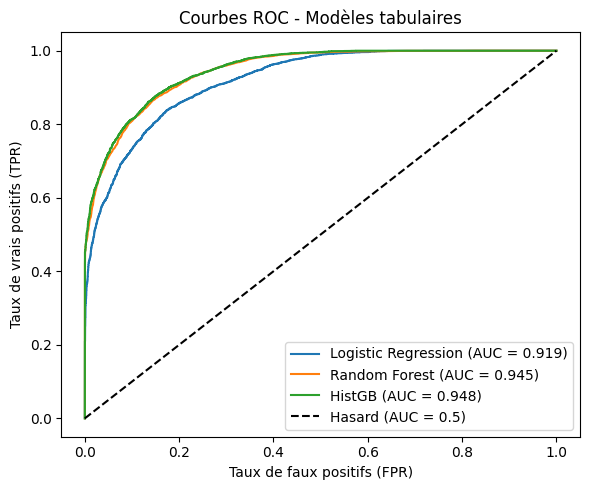

In [22]:
from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_proba_rf)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_proba_hgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_hgb, tpr_hgb, label=f"HistGB (AUC = {auc_hgb:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Hasard (AUC = 0.5)")

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC - Modèles tabulaires")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### 11.1. Distribution de la variable cible `Outcome`

Ce graphique montre le nombre de patient·es :

- non diabétiques (`Outcome = 0`)
- diabétiques (`Outcome = 1`)

Il permet de vérifier l'équilibre des classes avant l'entraînement des modèles.


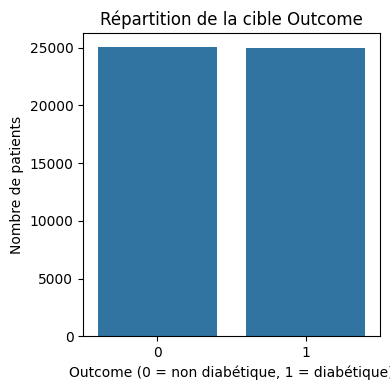

In [23]:
plt.figure(figsize=(4, 4))
sns.countplot(data=data_clean, x="Outcome")
plt.title("Répartition de la cible Outcome")
plt.xlabel("Outcome (0 = non diabétique, 1 = diabétique)")
plt.ylabel("Nombre de patients")
plt.tight_layout()
plt.show()


### 11.2. Matrice de corrélation des variables de base (style PIMA)

Nous regardons ici les corrélations entre les variables principales
du profil clinique :

- Pregnancies  
- Glycemia_gL (glycémie en g/L)  
- BloodPressure  
- SkinThickness  
- Insulin  
- BMI  
- DiabetesPedigreeFunction  
- Age  
- Outcome

Ce heatmap est proche de celui qu’on voit souvent dans l’analyse
classique du dataset PIMA.


Colonnes présentes dans data_clean :
['gender', 'Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level', 'Outcome', 'smoking_status']

Colonnes utilisées pour la matrice de corrélation :
['Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


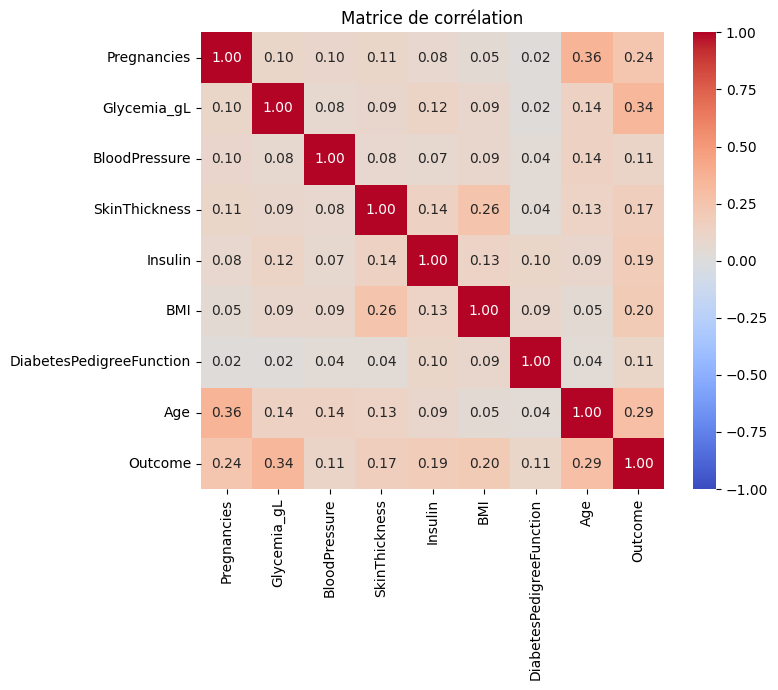

In [24]:
# Liste des colonnes PIMA-like qu'on aimerait avoir
pima_like_cols = [
    "Pregnancies",
    "Glycemia_gL",   # remplace Glucose
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",
]

print("Colonnes présentes dans data_clean :")
print(list(data_clean.columns))

# On vérifie lesquelles existent vraiment
missing = [c for c in pima_like_cols if c not in data_clean.columns]
if missing:
    print("\n⚠ Colonnes manquantes (pas trouvées dans data_clean) :")
    print(missing)

# On ne garde que les colonnes disponibles
available_cols = [c for c in pima_like_cols if c in data_clean.columns]
print("\nColonnes utilisées pour la matrice de corrélation :")
print(available_cols)

# Matrice de corrélation sur les colonnes dispo
corr_pima = data_clean[available_cols].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(
    corr_pima,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()


### 11.3. Histogrammes des variables numériques (style PIMA)

Nous affichons ici les histogrammes des principales variables numériques,
comme dans l'exploration classique du dataset PIMA :

- Pregnancies  
- Glycemia_gL  
- BloodPressure  
- SkinThickness  
- Insulin  
- BMI  
- DiabetesPedigreeFunction  
- Age  
- Outcome

Ces histogrammes permettent de visualiser la distribution (asymétrie,
valeurs extrêmes, etc.) de chaque variable.


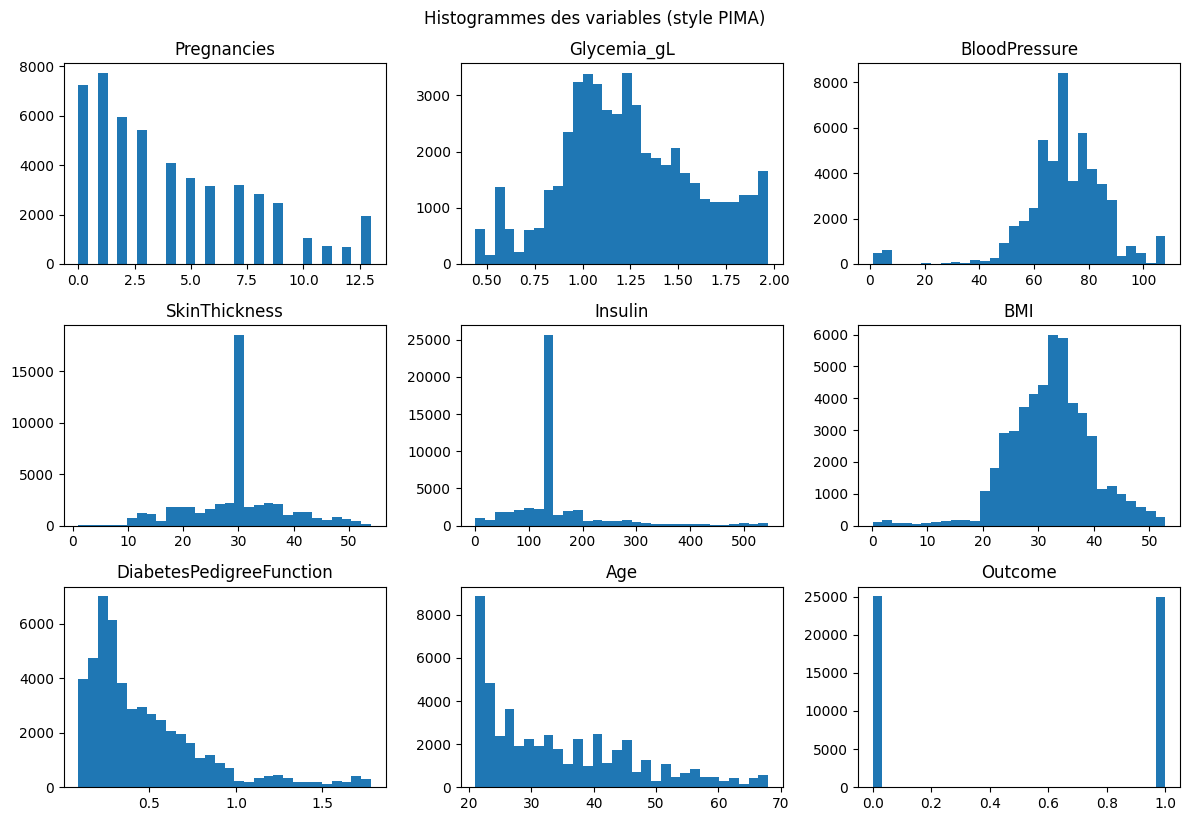

In [25]:
cols_hist = [
    "Pregnancies",
    "Glycemia_gL",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",
]

n_cols = 3
n_rows = int(np.ceil(len(cols_hist) / n_cols))

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols_hist, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(data_clean[col], bins=30)
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Histogrammes des variables (style PIMA)", y=1.02)
plt.show()


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from pathlib import Path

# 1) On part de data_clean (que tu as déjà construit plus haut)
#    -> colonnes rétiniennes supprimées
#    -> Glucose déjà convertie en g/L
#    -> zéros traités + imputations faites

target_column = "Outcome"
categorical_cols = ["gender", "smoking_status"]

# Toutes les colonnes sauf la cible et les catégorielles
numeric_cols = [
    col for col in data_clean.columns
    if col not in categorical_cols + [target_column]
]

print("Colonnes numériques :", numeric_cols)
print("Colonnes catégorielles :", categorical_cols)

# 2) Définir les transformers

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 3) Modèle RandomForest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# 4) Pipeline complet = prétraitement + modèle
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_clf),
])

# 5) Préparer X, y
X = data_clean.drop(columns=[target_column])
y = data_clean[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6) Entraînement
rf_pipeline.fit(X_train, y_train)

print("✅ Pipeline RandomForest entraîné")

# 7) Petite vérification de performance
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("ROC AUC :", roc_auc_score(y_test, y_proba))

# 8) Sauvegarde du pipeline dans ../models
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "diabetes_rf_pipeline.joblib"
joblib.dump(rf_pipeline, model_path)

print(f"\n💾 Modèle sauvegardé dans : {model_path}")


Colonnes numériques : ['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level']
Colonnes catégorielles : ['gender', 'smoking_status']
✅ Pipeline RandomForest entraîné

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5008
           1       0.85      0.87      0.86      4992

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

ROC AUC : 0.9446827383878103

💾 Modèle sauvegardé dans : ..\models\diabetes_rf_pipeline.joblib


Colonnes attendues par le pipeline côté API :
Numériques : ['Age', 'Pregnancies', 'Glycemia_gL', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'hypertension', 'heart_disease', 'HbA1c_level']
Catégorielles : ['gender', 'smoking_status']
